##Logistic Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import statsmodels.api as sm
from sklearn.utils import resample

###Loan default data

In [2]:
default = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)

# downsample the negatives to address class imbalance
indices = np.where(default['default'] == 'No')[0]
rng = np.random.RandomState(13)
rng.shuffle(indices)
n_pos = (default['default'] == 'Yes').sum()
default = default.drop(default.index[indices[n_pos:]])
default['default'] = (default['default'] == 'Yes').astype(int)
default['student'] = (default['student'] == 'Yes').astype(int)

# limit to single covariate
y = default.pop('default')
X = default['balance']

###Distribution of defaults over loan balance

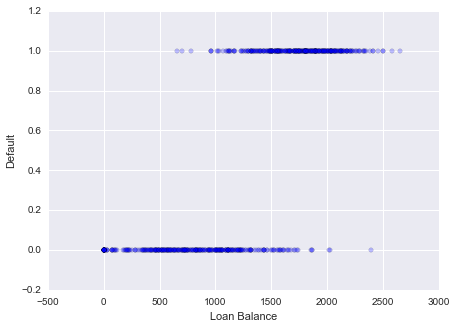

In [3]:
plt.figure(figsize=(7, 5)) 
plt.scatter(X, y, alpha=0.25)
plt.xlabel('Loan Balance')
plt.ylabel('Default'); 

###Linear probability model 

One thing we can do is fit a linear regression to the data in spite of the fact that we have a binary dependent variable. 

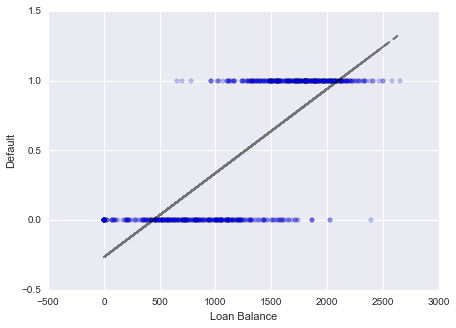

In [4]:
lpm = sm.OLS(y, sm.add_constant(X)).fit() 
fitted = lpm.fittedvalues

plt.figure(figsize=(7, 5)) 
plt.scatter(X, y, alpha=0.25)
plt.plot(X, fitted, linestyle='--', c='k', alpha=0.5)
plt.xlabel('Loan Balance')
plt.ylabel('Default'); 

Recall that the PMF for a Bernoulli random variable is 

$$\text{E}(y) = \pi^y (1-\pi)^{(y-1)}$$

And in this case, we are saying the relationship is linear, just as in linear regression, so the expected value of $y$ is simply $X\beta$. Now, because the variance of a Bernoulli random variable is 

$$\text{Var}(y) = \text{E}(y)\left[1 - \text{E}(y) \right] = \pi(1 - \pi) = X\beta(1 - X\beta)$$

We can see that the variance is explicitly dependent on $X$, and therefore we have *heteroskedasticity by construction*. In addition, our *errors are not normally distributed* because they can only take the values $-X\beta$ and $1-X\beta$. 

Two more problems: 

1. *Nonsensical predictions*: we get predicted values below 0 and above 1, values that are not observed in reality. 
2. *Functional form*: we probably expect diminishing returns in $X$. That is, there is a point at which increasing $X$ does not have much of a marginal effect on the probability of observing a 1 in the data.

###Logistic Regression

We can motivate our model of binary outcomes in terms of a discretization of a latent continuous variable, $Y^*$. That is, if we had the a perfectly measured dependent variable, it would take continuous values and we could run a model of the form 

$$Y^* = X\beta + u$$

That is, we could just run a linear model. It turns out that we often get a dichotomous representation of this underlying latent variable. For example, we are given a survey with a yes or no question: *Do you approve of the job the President is doing?* Our answer to this question is discrete, but it is a dichotomous representation of a continuous latent preference. 

So we make the following assumption:

$$
\begin{align*}
Y = \begin{cases}
    1 & \text{if}~~Y^* \geq 0 \\
    0 & \text{if}~~Y^* < 0 \\ 
\end{cases}
\end{align*}
$$

In turn, we can say 

$$
\begin{align*}
\text{Pr}(Y = 1) &= \text{Pr}(Y^* \geq 0) \\ 
    &= \text{Pr}(X\beta + u \geq 0) \\
    &= \text{Pr}(u \geq -X\beta) \\ 
    &= \text{Pr}(u \leq X\beta)
\end{align*}
$$

Now we just need to give the $u$s a probability distribution, and we will most often use the standard logistic distribution for this, which yields a distribution that looks basically like the standard normal distribution but with fatter tails. The PDF for the standard logistic distribution is given by 

$$\text{Pr}(u) = \frac{\text{exp}(u)}{\left[ 1 + \text{exp}(u) \right]^2}$$

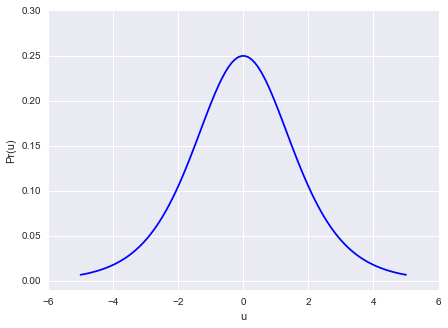

In [5]:
def logistic_pdf(x): return np.exp(x) / (1 + np.exp(x))**2

x = np.linspace(-5, 5, 100)
plt.figure(figsize=(7, 5))
plt.plot(x, logistic_pdf(x), 'b')
plt.xlabel('u'); plt.ylabel('Pr(u)'); plt.ylim([-0.01, 0.30]); 

What we would like to do is be able to obtain the *cumulative* probability that some value $u$ is less than a given value, namely $X\beta$. For this purpose we use the CDF of the standard logistic, which is given by 

$$\Lambda(u) = \int \lambda(u)du = \frac{\text{exp}(u)}{1 + \text{exp}(u)}$$

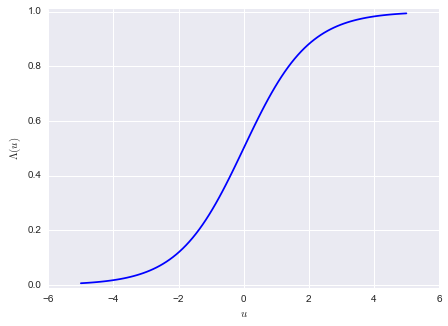

In [6]:
def logistic_cdf(x): return np.exp(x) / (1 + np.exp(x))

plt.figure(figsize=(7, 5))
plt.plot(x, logistic_cdf(x), 'b')
plt.xlabel('$u$'); plt.ylabel('$\Lambda(u)$'); plt.ylim([-0.01, 1.01]); 

Notice that this function appears to fit the data plotted above better than the linear function obtained from the fitted values in linear regression. Now, because we defined above that $\text{Pr}(y=1) = \text{Pr}(u \leq X\beta)$, we can rewrite this as 

$$\text{Pr}(y=1) = \Lambda(X\beta) = \frac{\text{exp}(X\beta)}{1 + \text{exp}(X\beta)}$$ 

In practical terms, what we are doing here is transforming the linear predictor (i.e., $X\beta$) onto the probability scale (i.e., to values between 0 and 1) via a *link function*. There are other choices for the link function, but the logistic is the canonical link function for modeling binary dependent variables. 

This is how we model the probability in logistic regression, and to obtain the probabilities for each observation in the data, given the data and the parameters, we can plug this into the Bernoulli likelihood function.

$$\mathcal{L} = \prod_{i=1}^N \left( \frac{\text{exp}(X_i\beta)}{1 + \text{exp}(X_i\beta)} \right)^{y_i} \left[ 1 - \left( \frac{\text{exp}(X_i\beta)}{1 + \text{exp}(X_i\beta)} \right) \right]^{(1 - y_i)} $$

And the log-likelihood is 

$$\text{ln}\mathcal{L} = \sum_{i=1}^N y_i ~ \text{ln} \left( \frac{\text{exp}(X_i\beta)}{1 + \text{exp}(X_i\beta)} \right) + (1 - y_i) ~ \text{ln} \left[ 1 - \left( \frac{\text{exp}(X_i\beta)}{1 + \text{exp}(X_i\beta)} \right) \right] $$

This is what we maximize with respect to the parameters to yield the maximum likelihood estimates. 

###Odds 

The odds of observing a success (i.e., 1 in the data) is the ratio of the probability of success to the probability of a failure. Thus, if the probability of a 1 is 0.75, we know the probability of a failure is 1 - 0.75, or 0.25. The ratio of these two probabilities is $\frac{0.75}{0.25} = 3$, which suggests that the odds of success are 3 to 1. 

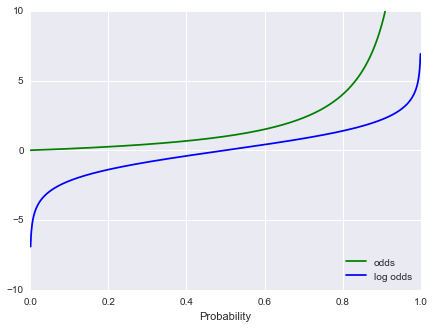

In [7]:
def odds(p): return p / (1 - p)
def log_odds(p): return np.log(odds(p))

probs = np.linspace(0.001, 0.999, 999)

plt.figure(figsize=(7, 5))
plt.plot(probs, odds(probs), 'g', label='odds')
plt.plot(probs, log_odds(probs), 'b', label='log odds')
plt.xlim([0, 1]); plt.ylim([-10, 10])
plt.xlabel('Probability'); plt.ylabel(''); plt.legend(loc='lower right'); 

Note that when we take the natural log of the odds: 

$$\text{ln}\left(\frac{p}{1-p}\right) = \text{ln} \left[ \frac{ \frac{\text{exp}(X\beta)}{1 + \text{exp}(X\beta)} }{ 1 - \left( \frac{ \text{exp}(X\beta) }{ 1 + \text{exp}(X\beta) } \right) } \right] = X\beta $$

What we obtain is the linear predictor. What this means is that the coefficient estimates in logistic regression are expressed in terms of the log of the odds of observing a success. But we don't typically think in log-odds, so we can exponentiate the coefficient estimates to put our estimates on the odds scale. Specifically, $\text{exp}(\hat{\beta})$ is the change in the odds of observing a success in response to a one-unit change in $X$. 

For example, if we have an estimate $\hat{\beta} = 1.4$, a one-unit change in $X$

* corresponds to a change in the log-odds of observing a success of 1.4
* corresponds to a change in the odds of observing a success of 4.06

###Predicted probabilities

Given coefficient estimates $\hat{\beta}$ that maximize the value of the log-likelihood for our data, we can use those estimates to obtain predicted probabilities $\hat{\pi}$ for $X$ values of interest. 

$$\hat{\pi} = \frac{\text{exp}(X\hat{\beta})}{1 + \text{exp}(X\hat{\beta})}$$ 

For example, instead of trying to interpret the coefficient estimates from the regression results in terms of the odds ratio or the log-odds, we can evaluate the predicted probability across the range of one of our covariates. There are two dominant ways to achieve this:

1. *Average case approach*: Evaluate $\hat{\pi}$ across the range of values for one covariate, holding all other covariates at their mean value. 
2. *Observed case approach*: Evaluate $\hat{\pi}$ across the range of values for one covariate, holding all other values of the covariates at their observed values. 

A special case of inference using predicted probabilities is known as *first differences*, where we sample from the posterior distribution of the estimates (about 1000 times) and evaluate the difference in the predicted probabilities for two substantively interesting values of a single covariate (e.g., $\bar{X}_j \pm \text{sd}(X_j)$). To get the posterior, we can either 

* sample from the multivariate normal distribution of the coeffiecient estimates
* use bootstrap estimates to simulate the sampling distribution of the estimates 

We are using the Bayesian notion of *posterior distribution* loosely here because we are not specifying a prior distribution on the parameters, which is the same as specifying a uniform, or noninformative, prior. 

###Fit a logistic regression in `statsmodels`

In [8]:
X = sm.add_constant(default)
logit = sm.Logit(y, X).fit()
print logit.summary()

Optimization terminated successfully.
         Current function value: 0.292468
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                  666
Model:                          Logit   Df Residuals:                      662
Method:                           MLE   Df Model:                            3
Date:                Wed, 28 Oct 2015   Pseudo R-squ.:                  0.5781
Time:                        14:23:18   Log-Likelihood:                -194.78
converged:                       True   LL-Null:                       -461.64
                                        LLR p-value:                2.366e-115
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -6.3687      0.780     -8.161      0.000        -7.898    -4.839
student       -0.9218      0.

At first glance, the balance of the loan has a reasonably strong association with the probability of loan default. Evaluate the odds ratios. 

In [9]:
print np.exp(logit.params)

const      0.001714
student    0.397789
balance    1.005499
income     0.999983
dtype: float64


Now let's look at the substantive effects of loan balance on the probability of loan default. In other words, let's evaluate predicted probabilities across relevant values of loan balance. To begin, numerically evaluate the sampling distribution for the coefficient estimates by obtaining estimates in 1000 bootstrap samples. 

In [10]:
def boot_logit_estimates(y, X, nboot):
    coefs = []
    for i in xrange(nboot):
        iX, iy = resample(X, y)
        model = sm.Logit(iy, iX).fit(disp=0) 
        coefs.append(model.params)
    return np.vstack(coefs)

boot_estimates = boot_logit_estimates(y, X, 1000)

Find the mean vector for the attributes in the data, then set up a range of counterfactual values of the variable of interest, in this case the full range of values of loan balance. 

In [11]:
average_case = np.mean(X, axis=0) 
balance_values = np.linspace(X['balance'].min(), X['balance'].max())

For each counterfactual value of balance and holding all other values at their mean, I want to evaluate the predicted probability of default for each bootstrap coefficient estimate. For each counterfactual value, I can then select the median predicted probability as well as the predicted probabilities at the upper and lower bounds (percentiles 0.025, 0.975), thus giving us a confidence interval for the predicted value.  

In [12]:
predicted_probabilities = []
for value in balance_values:
    average_case['balance'] = value
    linear_predictor = np.dot(average_case[np.newaxis,:], boot_estimates.T)
    predicted_probabilities.append(logistic_cdf(linear_predictor).ravel())
    
# get percentiles for boot predicted probs 
phats = [np.percentile(a, [0.025, 0.500, 0.975]) for a in predicted_probabilities]
phats = np.array(phats).T

Now we can plot the results. 

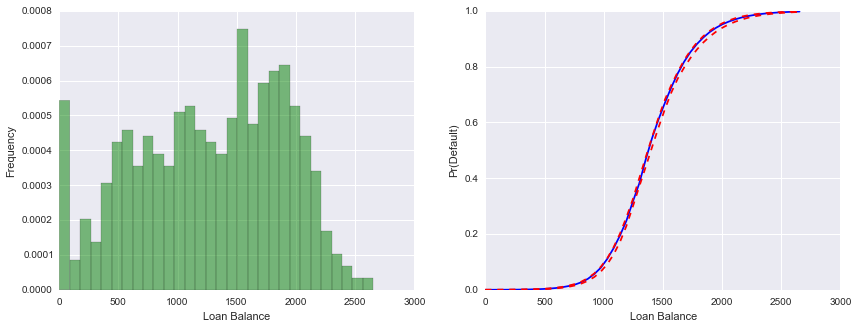

In [13]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.hist(X['balance'].values, normed=True, bins=30, alpha=0.50, color='g')
plt.xlabel('Loan Balance'); plt.ylabel('Frequency')

plt.subplot(122)
plt.plot(balance_values, phats[1,:], 'b')
plt.plot(balance_values, phats[0,:], 'r', linestyle='--')
plt.plot(balance_values, phats[2,:], 'r', linestyle='--')
plt.xlabel('Loan Balance'); plt.ylabel('Pr(Default)'); 